In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from astropy.stats import BoxLeastSquares

In [2]:
# I already have light curves

In [47]:
time001, flux001 = np.genfromtxt('l98-59-s001lc.txt', delimiter=',').T
time005, flux005 = np.genfromtxt('l98-59-s005lc.txt', delimiter=',').T

texp001 = 0.00138889
texp005 = 0.02083333

In [29]:
period_grid = np.exp(np.linspace(np.log(0.1), np.log(15), 50000))
duration = 0.04

bls_periods = np.zeros([4])
bls_t0s = np.zeros([4])
bls_depths = np.zeros([4])
time = np.r_[time001, time005]
flux = np.r_[flux001, flux005]

# planet 1
bls = BoxLeastSquares(time, flux)
bls_power = bls.power(period_grid, duration, oversample=20)

bls_power0 = bls_power

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 3*duration, bls_t0)

bls_periods[0] = bls_period
bls_t0s[0] = bls_t0
bls_depths[0] = bls_depth

# planet 2
bls = BoxLeastSquares(time[~transit_mask], flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

bls_periods[1] = bls_period
bls_t0s[1] = bls_t0
bls_depths[1] = bls_depth

# planet 3
bls = BoxLeastSquares(time[~transit_mask], flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

bls_periods[2] = bls_period
bls_t0s[2] = bls_t0
bls_depths[2] = bls_depth

# planet 4
bls = BoxLeastSquares(time[~transit_mask], flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

bls_periods[3] = bls_period
bls_t0s[3] = bls_t0
bls_depths[3] = bls_depth

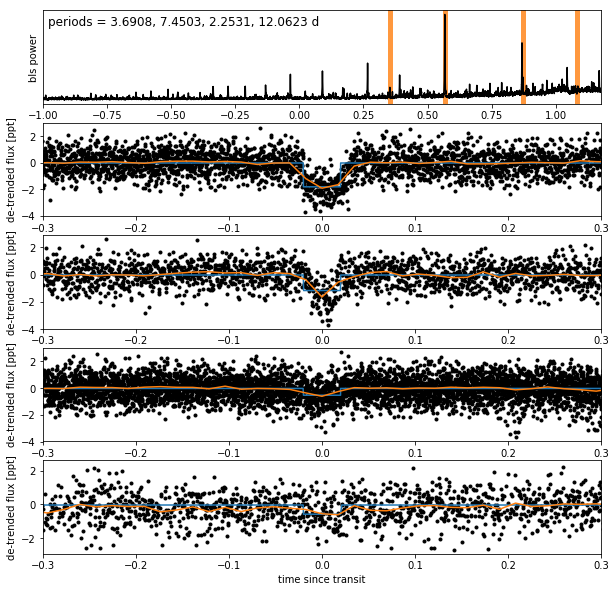

In [45]:
fig, axes = plt.subplots(5, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_periods[0]), color="C1", lw=5, alpha=0.8)
ax.axvline(np.log10(bls_periods[1]), color="C1", lw=5, alpha=0.8)
ax.axvline(np.log10(bls_periods[2]), color="C1", lw=5, alpha=0.8)
ax.axvline(np.log10(bls_periods[3]), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power0.period), bls_power0.power, "k")
ax.annotate("periods = {0:.4f}, {1:.4f}, {2:.4f}, {3:.4f} d".format(*bls_periods),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transits
bls = BoxLeastSquares(time, flux)
for i in range(4):
    ax = axes[i+1]
    x_fold = (time - bls_t0s[i] + 0.5*bls_periods[i])%bls_periods[i] - 0.5*bls_periods[i]
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], flux[m], ".k")
    inds = np.argsort(x_fold[m])
    ax.plot(x_fold[m][inds], bls.model(time, bls_periods[i], duration, bls_t0s[i])[m][inds])

    # Overplot the phase binned light curve
    bins = np.linspace(-1.31, 1.31, 152)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=flux )
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.3, 0.3)
    ax.set_ylabel("de-trended flux [ppt]")
    ax.set_xlabel("time since transit");

In [174]:
bls_t0s = np.array([-0.53609796, -5.07304732, -1.64429629])
bls_periods = np.array([3.69023187, 7.45116062, 2.25375899])
def build_model(mask=None, start=None):
    if mask is None:
        mask001 = np.ones(len(flux001), dtype=bool)
        mask005 = np.ones(len(flux005), dtype=bool)
    else:
        mask001, mask005 = mask
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean001 = pm.Normal("mean001", mu=0.0, sd=10.0)
        mean005 = pm.Normal("mean005", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.3, 0.2]))
        
        # Stellar parameters from Kostov et al (2018)
        R_star_kostov = 0.291, 0.025
#         M_star_kostov = 0.32, 0.025
        Rho_star_kostov = 18.0
        r_star = pm.Normal("r_star", mu=R_star_kostov[0], sd=R_star_kostov[1])

        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star_kostov), sd=0.1)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))

        # Prior to require physical parameters
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))


        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_periods[0:3]), sd=0.1, shape=3)
        t0 = pm.Normal("t0", mu=bls_t0s[0:3], sd=0.1, shape=3)
        logror = pm.Normal("logror", mu=np.log(np.sqrt(1e-3)*np.sqrt(bls_depths[0:3])),
                           sd=2, shape=3)
        ror = pm.Deterministic("r", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=[0,0.3,0], upper=[0.8,1,0.8], shape=3)
        b = pm.Deterministic("b", b_param * (1 + ror))

        ecc = pm.Bound(pm.Beta, lower=0.0, upper=0.8)("ecc", alpha=0.867, beta=3.03,
                                                       testval=[0.1,0.1,0.1], shape=3)

        omega = xo.distributions.Angle("omega", shape=3)
        
        # Log-uniform prior on ror
        pm.Potential("ror_prior_lo", tt.switch(tt.all(0.005 < ror), 0.0, -np.inf))
        pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))

        # Transit jitter & GP parameters
        logs2001 = pm.Normal("logs2001", mu=np.log(np.var(flux001[mask001])), sd=10)
        logs2005 = pm.Normal("logs2005", mu=np.log(np.var(flux005[mask005])), sd=10)
        
#         logS0001 = pm.Normal("logS0001", mu=np.log(np.var(flux001[mask001])), sd=10)
#         logw0001 = pm.Normal("logw0001", mu=np.log(2*np.pi/10), sd=10)
        logS0001 = pm.Normal("logS0001", mu=-3.71803952, sd=0.1)
        logw0001 = pm.Normal("logw0001", mu=0.60200341, sd=0.1)
        
        logS0005 = pm.Normal("logS0005", mu=np.log(0.1*np.var(flux005[mask005])), sd=10)
        logw0005 = pm.Normal("logw0005", mu=np.log(2*np.pi/10), sd=10)

#         logS0 = pm.Normal("logS0001", mu=np.log(0.01 * np.var(flux005[mask005])), sd=50)
#         logw0 = pm.Normal("logw0", mu=np.log(2*np.pi/10), sd=50)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", (r_star * ror / 0.009155))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, #m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            rho_star=rho_star,
            )
        
        a = pm.Deterministic("a", orbit.a)
        pm.Potential("ecc_prior", tt.switch((ecc < 1 - (1/a)), 0, -np.inf))

        # Compute the model light curve using starry
        light_curves001 = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=time001[mask001], texp=texp001)*1e3
        light_curve001 = pm.math.sum(light_curves001, axis=-1)
        
        light_curves005 = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=time005[mask005], texp=texp005)*1e3
        light_curve005 = pm.math.sum(light_curves005, axis=-1)
        
        pm.Deterministic("light_curve001", light_curve001)
        pm.Deterministic("light_curve005", light_curve005)
        model.light_curves001 = light_curves001
        model.light_curves005 = light_curves005

        # GP model for the light curve
        kernel001 = xo.gp.terms.SHOTerm(log_S0=logS0001, log_w0=logw0001, Q=1/np.sqrt(2))
        kernel005 = xo.gp.terms.SHOTerm(log_S0=logS0005, log_w0=logw0005, Q=1/np.sqrt(2))
#         kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp001 = xo.gp.GP(kernel001, flux001[mask001], tt.exp(logs2001) + tt.zeros(mask001.sum()), J=2)
        gp005 = xo.gp.GP(kernel005, flux005[mask005], tt.exp(logs2005) + tt.zeros(mask005.sum()), J=2)
        pm.Potential("transit_obs", gp001.log_likelihood(flux001[mask001] - light_curve001 - mean001) +
                    gp005.log_likelihood(flux005[mask005] - light_curve005 - mean005))
        pm.Deterministic("gp_pred001", gp001.predict())
        pm.Deterministic("gp_pred005", gp005.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pm.find_MAP(start=start, vars=[logs2001, logs2005])
        map_soln = pm.find_MAP(start=start, vars=[logS0001, logS0005, logw0005, logw0005])
#         map_soln = pm.find_MAP(start=map_soln, vars=[model.rb])
#         map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = pm.find_MAP(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

logp = -inf, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 122.32it/s]
logp = -inf, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 110.96it/s]
logp = -inf, ||grad|| = 0.54341: 100%|██████████| 3/3 [00:00<00:00, 72.49it/s]


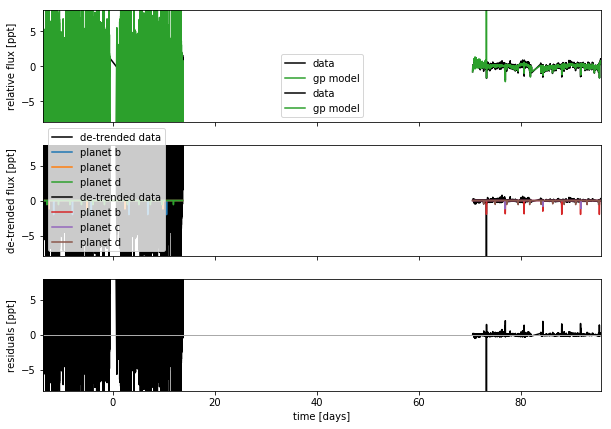

In [171]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask001 = np.ones(len(time001), dtype=bool)
        mask005 = np.ones(len(time005), dtype=bool)
    else:
        mask001, mask005 = mask
    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True, sharey=True)

    ax = axes[0]
    ax.plot(time001[mask001], flux001[mask001], "k", label="data")
    gp_mod001 = xo.utils.eval_in_model(model.gp_pred001, soln, model=model)
    gp_mod001 += soln["mean001"]
    ax.plot(time001[mask001], gp_mod001, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(time001[mask001], flux001[mask001] - gp_mod001, "k", label="de-trended data")
    light_curves001 = xo.utils.eval_in_model(model.light_curves001, soln, model=model)
    for i, l in enumerate(["b", "c", 'd']):
        mod = light_curves001[:, i]
        ax.plot(time001[mask001], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod001 + np.sum(light_curves001, axis=-1)
    ax.plot(time001[mask001], flux001[mask001] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(time001[mask001].min(), time001[mask001].max())
    ax.set_xlabel("time [days]")
    
    ax = axes[0]
    ax.plot(time005[mask005], flux005[mask005], "k", label="data")
    gp_mod005 = xo.utils.eval_in_model(model.gp_pred005, soln, model=model)
    gp_mod005 += soln["mean005"]
    ax.plot(time005[mask005], gp_mod005, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(time005[mask005], flux005[mask005] - gp_mod005, "k", label="de-trended data")
    light_curves005 = xo.utils.eval_in_model(model.light_curves005, soln, model=model)
    for i, l in enumerate(["b", "c", 'd']):
        mod = light_curves005[:, i]
        ax.plot(time005[mask005], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod005 + np.sum(light_curves005, axis=-1)
    ax.plot(time005[mask005], flux005[mask005] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(time001[mask001].min(), time005[mask005].max())
    ax.set_xlabel("time [days]")
    ax.set_ylim(-8,8)
    
    return fig
    
plot_light_curve(model0, map_soln0);

(-8.2, -7.8)

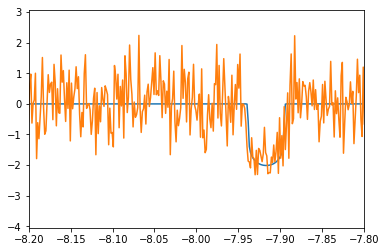

In [160]:
# plt.plot(time001, map_soln0['gp_pred'])
plt.plot(time001, map_soln0['light_curve001'])
plt.plot(time001, flux001)
plt.xlim(-8.2,-7.8)

(-4, 3)

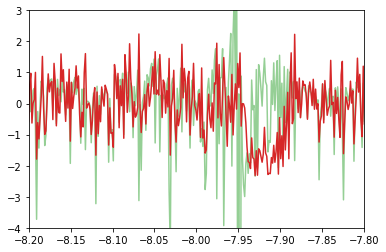

In [167]:

gp_mod001 = xo.utils.eval_in_model(model0.gp_pred001, map_soln0, model=model0)
gp_mod001 += map_soln0["mean001"]
plt.plot(time001, gp_mod001, color="C2", label="gp model", alpha=0.5)
plt.plot(time001, flux001, color="C3", label="gp model")
plt.xlim(-8.2,-7.8)
plt.ylim(-4,3)

In [168]:
map_soln0

{'mean001': array(0.),
 'mean005': array(0.),
 'u_star_quadlimbdark__': array([-1.09861229, -0.84729786]),
 'r_star': array(0.291),
 'logrho_star': array(2.89037176),
 'logP': array([1.30568929, 2.00836981, 0.81259948]),
 't0': array([-0.53609796, -5.07304732, -1.64429629]),
 'logror': array([-3.1605334 , -3.37995133, -3.76818122]),
 'b_param_interval__': array([0.00000000e+00, 2.22044605e-16, 0.00000000e+00]),
 'ecc_interval__': array([-2.52326042, -2.52326042, -2.52326042]),
 'omega_angle__': array([[0., 0., 0.],
        [1., 1., 1.]]),
 'logs2001': array(-0.30105708),
 'logs2005': array(-2.01376917),
 'logS0001': array(-0.30105708),
 'logw0001': array(-0.46470803),
 'logS0005': array(-2.01376917),
 'logw0005': array(-0.46470803),
 'u_star': array([0.3, 0.2]),
 'rho_star': array(18.),
 'r': array([0.04240312, 0.03404911, 0.02309403]),
 'b_param': array([0.4 , 0.65, 0.4 ]),
 'b': array([0.41696125, 0.67213192, 0.40923761]),
 'ecc': array([0.05939483, 0.05939483, 0.05939483]),
 'omega'

In [ ]:
{'mean': array(0.00769076),
 'u_star_quadlimbdark__': array([-1.10342789, -0.84845122]),
 'r_star': array(0.291),
 'logrho_star': array(2.72453811),
 'logP': array([1.30568929, 2.00836981, 0.81259948]),
 't0': array([-0.53609796, -5.07304732, -1.64429629]),
 'logror': array([-3.1935069 , -3.14907598, -3.68594956]),
 'b_param_interval__': array([-8.21344184,  1.17280329,  1.73787183]),
 'ecc_interval__': array([-1.99650333, -1.9454827 , -1.94182379]),
 'omega_angle__': array([[ 1.30158638e-08, -4.78195974e-08,  6.15118201e-08],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00]]),
 'logs2': array(-0.41557482),
 'logS0': array(-3.71803952),
 'logw0': array(0.60200341),
 'u_star': array([0.2992167 , 0.19988065]),
 'rho_star': array(15.2493688),
 'r': array([0.04102774, 0.04289174, 0.02507335]),
 'b_param': array([2.16730406e-04, 8.34555945e-01, 6.80333237e-01]),
 'b': array([2.25622364e-04, 8.70351502e-01, 6.97391474e-01]),
 'ecc': array([0.09565643, 0.10003741, 0.1003581 ]),
 'omega': array([1.57079631, 1.57079637, 1.57079627]),
 'period': array([3.69023187, 7.45116062, 2.25375899]),
 'r_pl': array([0.01193907, 0.0124815 , 0.00729635]),
 'r_ple': array([1.30410396, 1.363353  , 0.79697938]),
 'a': array([ 6.46738384, 10.33178794,  4.65548053]),
 'aAU': array([0.00871704, 0.01392566, 0.00627487]),
 'light_curve': array([0., 0., 0., ..., 0., 0., 0.]),
 'gp_pred': array([ 0.04173621,  0.04174493,  0.04176167, ..., -0.01944095,
        -0.01866173, -0.01788518])}

